In [4]:


import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import cm
# from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline


In [10]:
class GPR:
    """Guassin Process regression"""
    def __init__(self, optimize, optimizer, n_restarts_optimizer):
        self.optimize = optimize
        self.optimizer = optimizer
        self.n_restarts_optimizer = n_restarts_optimizer
        self.params = {"l": 0.5, "sigma_f": 0.3}

    def squared_exponential_kernel(self, x1, x2):
        """Compute squared-exponential kernel function"""
        dist_matrix = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
        return self.params["sigma_f"] ** 2 * np.exp(-0.5 / self.params["l"] ** 2 * dist_matrix)

    def fit(self, X, y):
        """GP model trainning"""
        self.train_X = np.asarray(X)
        self.train_y = np.asarray(y)

        def negative_log_likelihood_loss(params):
            """Hyperparameter optimization (RBF: l, sigma_f)"""
            self.params["l"] = params[0]
            self.params["sigma_f"] = params[1]

            Kyy = self.squared_exponential_kernel(self.train_X, self.train_X) + 1e-8*np.eye(len(self.train_X))
            neg_log_likelihood_loss = 0.5*self.train_y.T.dot(np.linalg.inv(Kyy)).dot(self.train_y) + 0.5 * np.linalg.slogdet(Kyy)[1] + 0.5 * len(self.train_X) * np.log(2 * np.pi)
            return neg_log_likelihood_loss.ravel()
        
        if self.optimize == True:
            res = minimize(negative_log_likelihood_loss, [self.params["l"], self.params["sigma_f"]], bounds=((1e-4, 1e4), (1e-4, 1e4)), method=self.optimizer)
            self.params["l"] = res.x[0]
            self.params["sigma_f"] = res.x[1]
    
    def predict(self, test_X):
        """GP model predicting"""
        X = np.asarray(test_X)
        Kff = self.squared_exponential_kernel(self.train_X, self.train_X)  # (N, N)
        Kyy = self.squared_exponential_kernel(X, X)  # (k, k)
        Kfy = self.squared_exponential_kernel(self.train_X, X)  # (N, k)
        Kff_inv = np.linalg.inv(Kff + 1e-8 * np.eye(len(self.train_X)))  # (N, N)
        
        mu = Kfy.T.dot(Kff_inv).dot(self.train_y)
        cov = Kyy - Kfy.T.dot(Kff_inv).dot(Kfy)
        return mu, cov


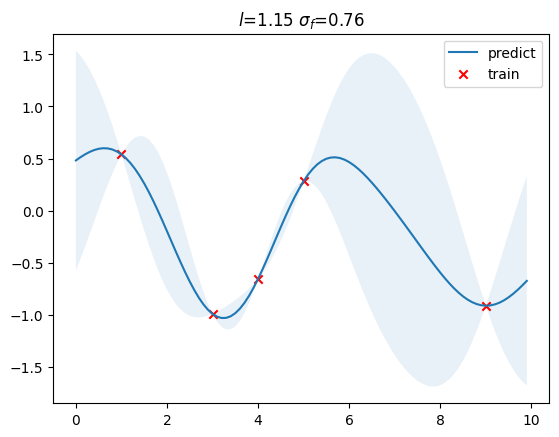

In [11]:
def y(x, noise_sigma=0.0):
    x = np.asarray(x)
    y = np.cos(x) + np.random.normal(0, noise_sigma, size=x.shape)
    return y.tolist()

train_X = np.array([3, 1, 4, 5, 9]).reshape(-1, 1)
train_y = y(train_X, noise_sigma=1e-4)
test_X = np.arange(0, 10, 0.1).reshape(-1, 1)

gpr = GPR(True,'L-BFGS-B',0)
gpr.fit(train_X, train_y)
mu, cov = gpr.predict(test_X)
test_y = mu.ravel()
uncertainty = 1.96 * np.sqrt(np.diag(cov))
plt.figure()
plt.title(r"$l$=%.2f $\sigma_f$=%.2f" % (gpr.params["l"], gpr.params["sigma_f"]))
plt.fill_between(test_X.ravel(), test_y + uncertainty, test_y - uncertainty, alpha=0.1)
plt.plot(test_X, test_y, label="predict")
plt.scatter(train_X, train_y, label="train", c="red", marker="x")
plt.legend()

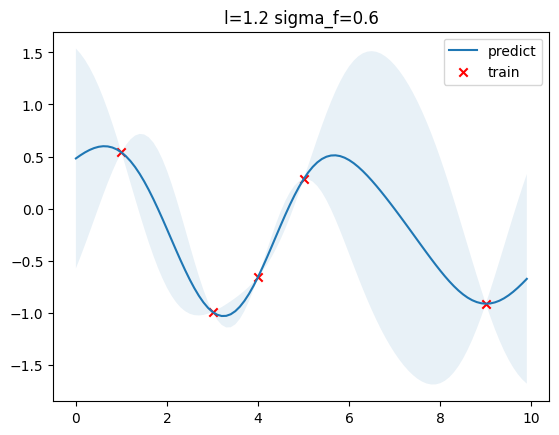

In [21]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from scipy.stats import multivariate_normal

# fit GPR
kernel = ConstantKernel(constant_value=0.2, constant_value_bounds=(1e-4, 1e4)) * RBF(length_scale=0.5, length_scale_bounds=(1e-4, 1e4))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=2)
gpr.fit(train_X, train_y)
mu, cov = gpr.predict(test_X, return_cov=True)
test_y = mu.ravel()
uncertainty = 1.96 * np.sqrt(np.diag(cov))

# plotting
plt.figure()
plt.title("l=%.1f sigma_f=%.1f" % (gpr.kernel_.k2.length_scale, gpr.kernel_.k1.constant_value))
plt.fill_between(test_X.ravel(), test_y + uncertainty, test_y - uncertainty, alpha=0.1)
plt.plot(test_X, test_y, label="predict")
plt.scatter(train_X, train_y, label="train", c="red", marker="x")
plt.legend()

# mvn = multivariate_normal(mu.ravel(), cov)
# print(mvn.cdf(np.asarray([0])))
# z = mvn.cdf(np.asarray([np.inf]))- mvn.cdf(np.asarray([0]))
# print(z)

Text(0.5, 0.92, 'l=1.30 sigma_f=0.38')

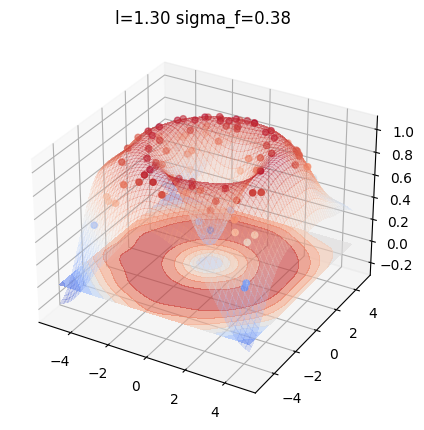

In [94]:
def y_2d(x, noise_sigma=0.0):
    x = np.asarray(x)
    y = np.sin(0.5 * np.linalg.norm(x, axis=1))
    y += np.random.normal(0, noise_sigma, size=y.shape)
    return y

train_X = np.random.uniform(-4, 4, (100, 2)).tolist()
# print(train_X)
# x= np.asarray(train_X)
# print(x)
train_y = y_2d(train_X,noise_sigma=1e-4)

test_d1 = np.arange(-5, 5, 0.2)
test_d2 = np.arange(-5, 5, 0.2)
test_d1, test_d2 = np.meshgrid(test_d1, test_d2)
test_X = [[d1, d2] for d1, d2 in zip(test_d1.ravel(), test_d2.ravel())]

gpr = GPR(True,'L-BFGS-B',0)
gpr.fit(train_X, train_y)
mu, cov = gpr.predict(test_X)
z = mu.reshape(test_d1.shape)

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(test_d1, test_d2, z, cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
ax.scatter(np.asarray(train_X)[:,0], np.asarray(train_X)[:,1], train_y, c=train_y, cmap=cm.coolwarm)
ax.contourf(test_d1, test_d2, z, zdir='z', offset=0, cmap=cm.coolwarm, alpha=0.6)
ax.set_title("l=%.2f sigma_f=%.2f" % (gpr.params["l"], gpr.params["sigma_f"]))


Text(0.5, 0.92, 'l=1.30 sigma_f=0.14')

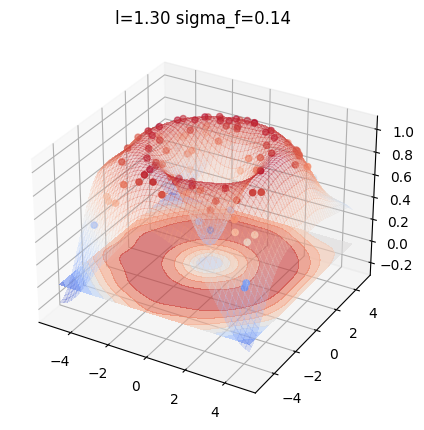

In [95]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

# fit GPR
kernel = ConstantKernel(constant_value=0.2, constant_value_bounds=(1e-4, 1e4)) * RBF(length_scale=0.5, length_scale_bounds=(1e-4, 1e4))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=2)
gpr.fit(train_X, train_y)
mu, cov = gpr.predict(test_X, return_cov=True)
test_y = mu.ravel()
uncertainty = 1.96 * np.sqrt(np.diag(cov))

z = mu.reshape(test_d1.shape)

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(test_d1, test_d2, z, cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
ax.scatter(np.asarray(train_X)[:,0], np.asarray(train_X)[:,1], train_y, c=train_y, cmap=cm.coolwarm)
ax.contourf(test_d1, test_d2, z, zdir='z', offset=0, cmap=cm.coolwarm, alpha=0.6)
ax.set_title("l=%.2f sigma_f=%.2f" % (gpr.kernel_.k2.length_scale, gpr.kernel_.k1.constant_value))

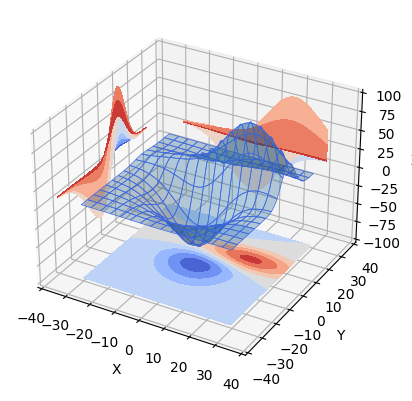

In [79]:

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
%matplotlib inline

ax = plt.figure().add_subplot(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)

# Plot the 3D surface
ax.plot_surface(X, Y, Z, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                alpha=0.3)

# Plot projections of the contours for each dimension.  By choosing offsets
# that match the appropriate axes limits, the projected contours will sit on
# the 'walls' of the graph
ax.contourf(X, Y, Z, zdir='z', offset=-100, cmap='coolwarm')
ax.contourf(X, Y, Z, zdir='x', offset=-40, cmap='coolwarm')
ax.contourf(X, Y, Z, zdir='y', offset=40, cmap='coolwarm')

ax.set(xlim=(-40, 40), ylim=(-40, 40), zlim=(-100, 100),
       xlabel='X', ylabel='Y', zlabel='Z')

plt.show()

(-2.0, 2.0)

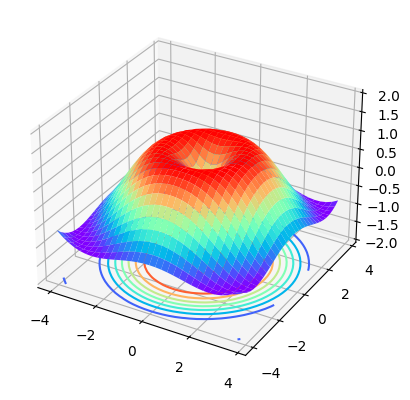

In [85]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
# from matplotlib import cm

%matplotlib inline

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

x = np.arange(-4, 4, 0.25)
y = np.arange(-4, 4, 0.25)

X, Y = np.meshgrid(x,y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1, cmap = plt.get_cmap("rainbow"))
ax.contour(X,Y,Z, zdir='z', offset = -2, cmap = plt.get_cmap("rainbow"))
ax.set_zlim(-2,2)

